# Stock Trend Prediction using Pretrained Transformer

This notebook fine-tunes a pretrained Transformer model (DistilBERT) to predict stock trends
(uptrend, downtrend, flat) based on news titles.

The model is evaluated using accuracy, precision, recall and F1-score on a held-out test set.

In [1]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [2]:
# Install required libraries (run once)
%pip install transformers torch scikit-learn
%pip install tf-keras
%pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Core libraries
import pandas as pd
import numpy as np
import torch

# Hugging Face Transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

# Evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [4]:
# Load the dataset
df = pd.read_csv("stock_trend.csv")

# Display first 10 rows 
df.head(10)

,Title,Time,Name,Quote,Before,After
0,100 startups participate in Maxis' Market Acce...,2019-12-12T23:50:12+08:00,MAXIS,6012,5.160,5.110
1,16.89% stake in Subur Tiasa traded off-market,2020-02-20T22:41:12+08:00,SUBUR,6904,0.610,0.610
2,Najib wanted 1MDB's Genting Sanyen deal sped u...,2020-07-16T17:42:30+08:00,GENTING,3182,4.080,4.060
3,"25bps OPR cut likely in 2H20, says Manulife",2020-01-16T17:03:43+08:00,MANULFE,1058,2.420,2.420
4,A 25-month extension on concession pushes Phar...,2019-11-11T10:49:58+08:00,PHARMA,7081,2.620,2.430
5,3.7% of Yong Tai transacted off-market,2019-09-05T19:55:54+08:00,YONGTAI,7066,0.195,0.200
6,"3A, Ruberex, Thriven, Kanger, UniWall",2020-03-04T13:23:15+08:00,KANGER,170,0.125,0.120
7,40% stake in IWH-CREC may cost Ekovest RM1.5b,2020-09-16T10:00:00+08:00,EKOVEST,8877,0.610,0.580
8,4.41% Kronologi Asia shares traded off-market,2020-02-12T23:54:51+08:00,KRONO,176,0.895,0.890
9,4.96% of MMAG traded off market,2019-07-23T22:42:17+08:00,MMAG,34,0.245,0.235


In [5]:
df.columns

Index(['Title', 'Time', 'Name', 'Quote', 'Before', 'After'], dtype='object')

In [6]:
df["price_change"] = (df["After"] - df["Before"]) / df["Before"]

def get_trend(change):
    if change > 0.10:
        return "uptrend"
    elif change < -0.10:
        return "downtrend"
    else:
        return "flat"

df["trend"] = df["price_change"].apply(get_trend)

df[["Before", "After", "price_change", "trend"]].head(10)

,Before,After,price_change,trend
0,5.160,5.110,-0.009690,flat
1,0.610,0.610,0.000000,flat
2,4.080,4.060,-0.004902,flat
3,2.420,2.420,0.000000,flat
4,2.620,2.430,-0.072519,flat
5,0.195,0.200,0.025641,flat
6,0.125,0.120,-0.040000,flat
7,0.610,0.580,-0.049180,flat
8,0.895,0.890,-0.005587,flat
9,0.245,0.235,-0.040816,flat


In [7]:
# Map trend labels to numeric values
label_map = {
    "downtrend": 0,
    "flat": 1,
    "uptrend": 2
}

df["label"] = df["trend"].map(label_map)
df[["Title", "trend", "label"]].head(10)

,Title,trend,label
0,100 startups participate in Maxis' Market Acce...,flat,1
1,16.89% stake in Subur Tiasa traded off-market,flat,1
2,Najib wanted 1MDB's Genting Sanyen deal sped u...,flat,1
3,"25bps OPR cut likely in 2H20, says Manulife",flat,1
4,A 25-month extension on concession pushes Phar...,flat,1
5,3.7% of Yong Tai transacted off-market,flat,1
6,"3A, Ruberex, Thriven, Kanger, UniWall",flat,1
7,40% stake in IWH-CREC may cost Ekovest RM1.5b,flat,1
8,4.41% Kronologi Asia shares traded off-market,flat,1
9,4.96% of MMAG traded off market,flat,1


In [8]:
df["label"].value_counts()

label
1    22626
2     1232
0      530
Name: count, dtype: int64

In [9]:
# Split into training (70%) and temporary (30%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Title"].tolist(),
    df["label"].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=df["label"]
)

# Split temporary set into validation (20%) and test (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=1/3,
    random_state=42,
    stratify=temp_labels
)

len(train_texts), len(val_texts), len(test_texts)

(17071, 4878, 2439)

In [10]:
# Load pretrained BERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [11]:
# Tokenize the datasets
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=64
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=64
)

test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=64
)

In [12]:
# Custom dataset class for PyTorch
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
# Create dataset objects
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

In [14]:
# Load pretrained BERT model for sequence classification
# num_labels = 3 (downtrend, flat, uptrend)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Function to compute accuracy, precision, recall, and F1-score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [17]:
# Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
)

In [18]:
# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

c:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.385400,0.349228,0.927634,0.860505,0.927634,0.892810


c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=4268, training_loss=0.3562895302026207, metrics={'train_runtime': 5403.0302, 'train_samples_per_second': 3.16, 'train_steps_per_second': 0.79, 'total_flos': 282673911305088.0, 'train_loss': 0.3562895302026207, 'epoch': 1.0})

In [19]:
# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)

print("Test Results:")
test_results

c:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Results:


c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.3629675805568695,
 'eval_accuracy': 0.9278392783927839,
 'eval_precision': 0.860885726528442,
 'eval_recall': 0.9278392783927839,
 'eval_f1': 0.8931094372619609,
 'eval_runtime': 64.7975,
 'eval_samples_per_second': 37.64,
 'eval_steps_per_second': 9.414,
 'epoch': 1.0}

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get raw predictions
predictions = trainer.predict(test_dataset)

# Predicted labels
y_pred = np.argmax(predictions.predictions, axis=1)

# True labels
y_true = predictions.label_ids

c:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


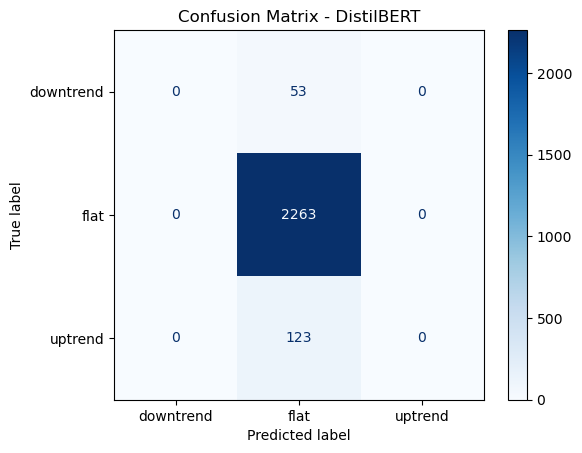

In [21]:
# Define label names in correct order
label_names = ["downtrend", "flat", "uptrend"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - DistilBERT")
plt.show()
